# Objetivo:

Classificar imagens como "dog" (cachorro) ou "cat" (gato) usando a biblioteca PyTorch para aprendizado de máquina e deep learning.

#### Subobjetivos:

Preparação dos dados: Carregar e pré-processar o conjunto de imagens, convertendo-as em tensores PyTorch e normalizando os valores dos pixels.

Criação do modelo: Definir e construir a arquitetura da rede neural usando PyTorch, incluindo camadas convolucionais, camadas de ativação e camadas totalmente conectadas.

Treinamento do modelo: Utilizar o conjunto de treinamento para ajustar os pesos da rede neural através do processo de backpropagation e gradiente descendente.

Avaliação do modelo: Usar o conjunto de teste para avaliar a precisão e desempenho do modelo classificador.

Otimização e ajuste: Experimentar diferentes hiperparâmetros, funções de perda e otimizadores para melhorar a performance do modelo.

Visualização dos resultados: Analisar as predições do modelo e verificar como ele está classificando corretamente as imagens.

# Resumo:

O objetivo deste projeto é construir um classificador de imagens utilizando a biblioteca PyTorch para diferenciar entre imagens de "dog" e "cat". Será realizado o pré-processamento dos dados, a criação de uma rede neural e seu treinamento usando um conjunto de imagens rotuladas. O modelo será avaliado com um conjunto de teste para verificar sua capacidade de generalização e acurácia. Com ajustes e otimizações, espera-se que o classificador alcance um bom desempenho nas predições de novas imagens.

### Dificuldades 

- Entender a arquitetura da rede neural
- Preparar o conjunto de imagens na resolução ideal
- Construir a rede neural e entender seu funcionamento 
- Overfitting e underfitting: overfitting (ajuste excessivo aos dados de treinamento) ou underfitting (falta de capacidade do modelo em generalizar).
- Escolha de hiperparâmetros
- Custo computacional (colab limitando o uso de gpu)

In [2]:
# Verificando a disponibilidade de CPU ou GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   106M      0  0:00:07  0:00:07 --:--:-- 86.4M
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


In [5]:
# Imagem para previsão
import urllib.request
from PIL import Image

# URL da imagem
url = "https://img.freepik.com/fotos-gratis/beagles-filhotes-procurando-algo_1150-18193.jpg"

# Faz o download da imagem
urllib.request.urlretrieve(url, "beagles-filhotes-procurando-algo_1150-18193.jpg")

# Abre a imagem usando o PIL
imagem = Image.open("beagles-filhotes-procurando-algo_1150-18193.jpg")

# Redimensiona a imagem para um tamanho específico (por exemplo, 300x300 pixels)
# 224x224, para alguns modelos
# modelo google utiliza 299x299
tamanho_redimensionado = (224, 224)
imagem_redimensionada = imagem.resize(tamanho_redimensionado)

# Salva a imagem redimensionada
imagem_redimensionada.save("imagem_de_cachorro_redimensionada.jpg")

In [6]:
import os
import tensorflow as tf

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [7]:
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch.nn as nn
import torch.optim as optim
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [8]:
# Defina o diretório raiz das pastas de treinamento e teste
root_dir = 'Imagens'

# Nome das pastas de treinamento e teste
train_folder_name = 'treinamento'
test_folder_name = 'teste'

# Caminhos para as pastas de treinamento e teste
train_folder_path = os.path.join(root_dir, train_folder_name)
test_folder_path = os.path.join(root_dir, test_folder_name)

# Criando as pastas de treinamento e teste, se ainda não existirem
os.makedirs(train_folder_path, exist_ok=True)
os.makedirs(test_folder_path, exist_ok=True)

In [9]:
import random
import shutil
from PIL import Image

# Caminho para a pasta raiz
root_folder = '/content/PetImages'

# Caminho para as pastas de treinamento e teste
train_folder = '/content/Imagens/treinamento'
test_folder = '/content/Imagens/teste'

# Tamanho das imagens
resize_size = (224, 224)

# Proporção de divisão entre treinamento e teste (por exemplo, 0.8 para 80% de treinamento e 20% de teste)
train_ratio = 0.8

# Criando as pastas de treinamento e teste
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Percorra as subpastas de "Dog" e "Cat"
for class_folder in ["Dog", "Cat"]:
    class_root = os.path.join(root_folder, class_folder)

    # Obtenha a lista de nomes de arquivo das imagens na subpasta atual
    filenames = os.listdir(class_root)

    # Embaralhe a lista de nomes de arquivo para garantir uma divisão aleatória entre treinamento e teste
    random.shuffle(filenames)

    # Calcula o índice de divisão com base na proporção de treinamento definida
    split_index = int(len(filenames) * train_ratio)

    # Divide a lista de nomes de arquivo em treinamento e teste
    train_filenames = filenames[:split_index]
    test_filenames = filenames[split_index:]

    # Movendo os arquivos de treinamento para a pasta de treinamento
    for filename in train_filenames:
        src = os.path.join(class_root, filename)
        dst = os.path.join(train_folder, class_folder, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        #shutil.copyfile(src, dst)

        # Verificando se o arquivo é uma imagem antes de abrir
        if os.path.isfile(src) and src.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Redimensionando a imagem ao copiá-la
            img = Image.open(src).resize(resize_size)
            img.save(dst)

    # Movendo os arquivos de teste para a pasta de teste
    for filename in test_filenames:
        src = os.path.join(class_root, filename)
        dst = os.path.join(test_folder, class_folder, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        #shutil.copyfile(src, dst)

        # Verifique se o arquivo é uma imagem antes de abrir
        if os.path.isfile(src) and src.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Redimensione a imagem ao copiá-la
            img = Image.open(src).resize(resize_size)
            img.save(dst)

print(f'Todas as imagens foram redimensionadas e separadas em treino e teste(validação)')

Todas as imagens foram redimensionadas e separadas em treino e teste(validação)


In [10]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

# Define o caminho para as pastas de treinamento e teste
train_folder = '/content/Imagens/treinamento/'
test_folder = '/content/Imagens/teste/'

# Define transformações para aplicar às imagens
transform = ToTensor()  # Converte a imagem em um tensor do PyTorch

# Crie conjuntos de dados para treinamento e teste
train_dataset = ImageFolder(train_folder, transform=transform)
test_dataset = ImageFolder(test_folder, transform=transform)

# Crie carregadores de dados para treinamento e teste
batch_size = 32  # Define o tamanho do lote
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Número de Épocas de treinamento
epocas = 10

# Criar uma pasta para salvar os modelos
folder_path = 'Modelos'
os.makedirs(folder_path, exist_ok=True)

In [12]:
# Definindo Funções de treinamento e cálculo da acurácia dos modelos
# Função de treinamento
def treinamento():
    # Defina o número de épocas de treinamento
    num_epochs = epocas
    inicio = time.time()
    # Lista para armazenar os valores de perda e acurácia
    loss_values = []
    accuracy_values = []
    #epoch_times = []

    # Treine o modelo
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        epoch_start = time.time() # Tempo de início da época

        for images, labels in train_loader:
            # Mova as imagens e as etiquetas para a GPU, se disponível
            images = images.to(device)
            labels = labels.to(device)

            # Zere os gradientes dos parâmetros
            optimizer.zero_grad()

            # Faça as previsões
            outputs = model(images)

            # Calcule a perda
            loss = criterion(outputs, labels)

            # Calcule a regularização L2
            l2_lambda = 0.001  # Fator de regularização L2
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param)

            # Adicione a regularização L2 à perda
            loss += l2_lambda * l2_reg

            # Faça a retropropagação e atualize os parâmetros
            loss.backward()
            optimizer.step()

            # Atualize a perda acumulada
            running_loss += loss.item()

            # Calcule a acurácia para as previsões atuais
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcule a perda média para a época atual
        epoch_loss = running_loss / len(train_loader)

        # Calcule a acurácia para a época atual
        epoch_accuracy = 100 * correct / total

        # Calcular o tempo decorrido na época atual
        epoch_time = (time.time() - epoch_start)/60

        # Imprima a perda média e a acurácia da época
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Tempo: {epoch_time:.2f} min')

        loss_values.append(epoch_loss) # Salvando os valores de loss e accuracy
        accuracy_values.append(epoch_accuracy)

    # Criando um dataframe com os valores de perda
    loss_data = {"Epoch": range(1, num_epochs + 1),
                "Loss": loss_values}
    loss_df = pd.DataFrame(loss_data)

    # Gráfico de linha para a perda
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 5))
    plt.title("Loss")
    sns.lineplot(data=loss_df, x="Epoch", y="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Crie um dataframe com os valores de acurácia
    accuracy_data = {"Epoch": range(1, num_epochs + 1),
                    "Accuracy": accuracy_values}
    accuracy_df = pd.DataFrame(accuracy_data)

    # Gráfico de linha para a acurácia
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 5))
    plt.title("Accuracy")
    sns.lineplot(data=accuracy_df, x="Epoch", y="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    final = time.time()
    tempo = (final - inicio)/60
    print(f'Tempo de Treinamento: {tempo:.0f} minutos')

# Função da acurácia
#def acuracia():
    model.eval()  # Mude para o modo de avaliação

    correct = 0
    total = 0

    predictions = []
    true_labels = []

    # Desative o cálculo do gradiente para acelerar a inferência
    with torch.no_grad():
        for images, labels in test_loader:
            # Mova as imagens e as etiquetas para a GPU, se disponível
            images = images.to(device)
            labels = labels.to(device)

            # Faça as previsões
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Atualize o total de amostras e o número de previsões corretas
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Salve as previsões e rótulos verdadeiros para calcular as métricas adicionais
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    # Calcule a acurácia do modelo
    accuracy = round((correct / total)*100,2)
    print(f'Acurácia do modelo no conjunto de teste: {accuracy}%')

    # Matriz de confusão
    cm = confusion_matrix(true_labels, predictions)
    print("Matriz de Confusão:")
    print(cm)

    # Relatório de classificação
    cr = classification_report(true_labels, predictions)
    print("Relatório de Classificação:")
    print(cr)

    # Área sob a curva ROC
    auc = roc_auc_score(true_labels, predictions)
    print(f"Área sob a curva ROC: {auc:.4f}")
    print('')
    print('-'*50)
    print('')
    print('Previsão com imagem de Cachorro')
    print('')

    # Gerando uma previsão de imagem
    import torch.nn.functional as F
    # Carregue a imagem de teste e realize as transformações necessárias
    test_image = Image.open("/content/imagem_de_cachorro_redimensionada.jpg")
    test_image = transform(test_image).unsqueeze(0)  # Adicione uma dimensão extra para representar o batch

    # Coloque o modelo no modo de avaliação
    model.eval()

    # Mova a imagem para o dispositivo correto
    test_image = test_image.to(device)

    # Faça a previsão
    outputs = model(test_image)
    probabilities = F.softmax(outputs, dim=1)

    # Converta as probabilidades em rótulos previstos
    _, predicted = torch.max(outputs.data, 1)

    # Obtenha a probabilidade correspondente à classe prevista
    predicted_probability = (probabilities[0][predicted.item()].item())*100

    # Imprima o rótulo previsto e a probabilidade correspondente
    print(f"Rótulo previsto: {predicted.item()}")
    print(f"Probabilidade de acerto: {predicted_probability:.2f} %")
    print('')
    print('-'*50)
    print('Legenda: 0 = Gato // 1 = Cachorro')
    print('')

In [ ]:
# Matriz de Confusão: É uma tabela que mostra a contagem de previsões corretas e incorretas para cada classe.
# Com base nessa matriz, você pode calcular métricas como precisão, recall, taxa de verdadeiros positivos, taxa de falsos positivos, etc.

# Precisão: A precisão é a proporção de previsões corretas para uma classe específica em relação ao total de previsões para essa classe.
# É uma métrica útil quando o equilíbrio de classes é desigual.

# Recall (Sensibilidade): O recall é a proporção de previsões corretas para uma classe específica em relação ao número total de amostras dessa classe.
# É útil quando o foco está em identificar todos os exemplos positivos corretamente.

# F1-Score: O F1-Score é uma medida de equilíbrio entre a precisão e o recall.
#  É a média harmônica entre essas duas métricas e pode ser útil quando o equilíbrio entre as classes é importante.

# AUC-ROC: A área sob a curva ROC (Receiver Operating Characteristic) é uma métrica que avalia a capacidade do modelo de distinguir entre classes positivas e negativas.
# É particularmente útil quando há um desequilíbrio entre as classes.

In [ ]:
# 1 modelo
# Modelo Simples
# Arquitetura do modelo
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(16 * 112 * 112, 2)  # Número de classes é 2 (dog, cat)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Crie uma instância do modelo
model = SimpleModel().to(device)

# Movendo o modelo para a GPU, se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Função de perda
criterion = nn.CrossEntropyLoss()

# Ootimizador
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)  # Adicione weight_decay para a regularização L2

treinamento()

# Salvar o modelo na pasta criada
file_path = os.path.join(folder_path, 'modelosimples1.pth')
torch.save(model.state_dict(), file_path)

Epoch [1/20], Loss: 0.7319, Accuracy: 60.29%
Epoch [2/20], Loss: 0.6501, Accuracy: 63.92%
Epoch [3/20], Loss: 0.6339, Accuracy: 65.82%
Epoch [4/20], Loss: 0.6176, Accuracy: 67.38%
Epoch [5/20], Loss: 0.5952, Accuracy: 69.27%
Epoch [6/20], Loss: 0.5681, Accuracy: 71.62%
Epoch [7/20], Loss: 0.5477, Accuracy: 72.84%
Epoch [8/20], Loss: 0.5287, Accuracy: 74.81%
Epoch [9/20], Loss: 0.5018, Accuracy: 76.05%
Epoch [10/20], Loss: 0.4813, Accuracy: 77.65%
Epoch [11/20], Loss: 0.4580, Accuracy: 78.78%
Epoch [12/20], Loss: 0.4324, Accuracy: 80.97%
Epoch [13/20], Loss: 0.4159, Accuracy: 81.66%
Epoch [14/20], Loss: 0.3919, Accuracy: 83.27%
Epoch [15/20], Loss: 0.3688, Accuracy: 84.42%
Epoch [16/20], Loss: 0.3531, Accuracy: 85.05%
Epoch [17/20], Loss: 0.3329, Accuracy: 86.38%
Epoch [18/20], Loss: 0.3149, Accuracy: 87.57%
Epoch [19/20], Loss: 0.3015, Accuracy: 88.29%
Epoch [20/20], Loss: 0.2826, Accuracy: 89.38%
Acurácia do modelo no conjunto de teste: 69.81%
Tempo de execução 9181 segundos


In [ ]:
# # modelo simles com 10x mais neurônios, modelo extremamente demorado , cerca de 20x
# # Modelo Simples
# # Defina a arquitetura do modelo
# class SimpleModel(nn.Module):
#     def __init__(self):
#         super(SimpleModel, self).__init__()
#         self.conv = nn.Conv2d(3, 160, kernel_size=3, stride=1, padding=1)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         self.fc = nn.Linear(160 * 112 * 112, 2)  # Número de classes é 2 (dog, cat)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# model = SimpleModel().to(device)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()

# # Defina o otimizador
# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)  # Adicione weight_decay para a regularização L2

# treinamento()

# file_path = os.path.join(folder_path, 'modelosimples2.pth')
# torch.save(model.state_dict(), file_path)

In [ ]:
# Modelo 3
# Modelo Simples com Adam
# Defina a arquitetura do modelo
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(16 * 112 * 112, 2)  # Número de classes é 2 (dog, cat)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Crie uma instância do modelo
model = SimpleModel().to(device)

# Movendo o modelo para a GPU, se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Defina a função de perda
criterion = nn.CrossEntropyLoss()

# Defina o otimizador
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)  # Adicione weight_decay para a regularização L2

# Defina o número de épocas de treinamento
num_epochs = epocas

treinamento()

# Salvar o modelo na pasta criada
file_path = os.path.join(folder_path, 'modelosimples1.pth')
torch.save(model.state_dict(), file_path)

In [ ]:
# Carregar o modelo
# model = SimpleModel()  # Instanciar o modelo com a mesma arquitetura
# model.load_state_dict(torch.load('ModeloSimples.pth'))

In [ ]:
# Adcionando mais camadas e regularização

# Defina a arquitetura do modelo
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64 * 28 * 28, 2)  # Número de classes é 2 (dog, cat)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = DeepModel().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

treinamento()

file_path = os.path.join(folder_path, 'modeloDeepModel1.pth')
torch.save(model.state_dict(), file_path)

In [ ]:
# Adicionando camada de dropout e Adam

class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(64 * 28 * 28, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = DeepModel().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

treinamento()

file_path = os.path.join(folder_path, 'modeloDeepModel2.pth')
torch.save(model.state_dict(), file_path)

In [ ]:
# Tornando o modelo mais complexo e mudando Adam para RMSprop

# Defina a arquitetura da rede com maior complexidade
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(192 * 28 * 28, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepModel().to(device)

# Definir o otimizador RMSprop
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

treinamento()

file_path = os.path.join(folder_path, 'modeloDeepModel3.pth')
torch.save(model.state_dict(), file_path)

In [ ]:
# Tornando o modelo mais complexo e mudando RMSprop para Adagrad

# Defina a arquitetura da rede com maior complexidade
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(192 * 28 * 28, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepModel().to(device)

# Definir o otimizador Adagrad
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

treinamento()

file_path = os.path.join(folder_path, 'modeloDeepModel4.pth')
torch.save(model.state_dict(), file_path)

In [ ]:
# modelo 10x mais complexo com Adagrad

# Arquitetura da rede com maior complexidade
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 480, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(480, 960, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(960, 1920, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(1920 * 28 * 28, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepModel().to(device)

# Definir o otimizador Adagrad
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

treinamento()

file_path = os.path.join(folder_path, 'modeloDeepModel5.pth')
torch.save(model.state_dict(), file_path)

In [ ]:
# Refinando o modelo
# Adicionando camada de dropout e Adam
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(64 * 28 * 28, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = DeepModel().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

treinamento()

# Salvar o modelo na pasta criada
file_path = os.path.join(folder_path, 'modeloDeepModel5.pth')
torch.save(model.state_dict(), file_path)

Epoch [1/5], Loss: 0.7062, Accuracy: 51.52%
Epoch [2/5], Loss: 0.6655, Accuracy: 61.44%


KeyboardInterrupt: ignored

In [ ]:
# # Automatizando o modelo para parar de treinar somente com 95% de acurácia ou mais

# # Adicionando camada de dropout e Adam

# class DeepModel(nn.Module):
#     def __init__(self):
#         super(DeepModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
#         self.dropout1 = nn.Dropout(0.2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2)
#         self.dropout2 = nn.Dropout(0.2)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2)
#         self.dropout3 = nn.Dropout(0.2)
#         self.fc = nn.Linear(64 * 28 * 28, 2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)
#         x = self.dropout1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.pool2(x)
#         x = self.dropout2(x)
#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.pool3(x)
#         x = self.dropout3(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# model = DeepModel().to(device)

# # Movendo o modelo para a GPU, se disponível
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Definir o otimizador RMSprop
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Definir a função de perda
# criterion = nn.CrossEntropyLoss()

# # Definindo Funções de treinamento de cálculo da acurácia dos modelos
# # Função de treinamento
# def treinamento():
#     # Defina o número de épocas de treinamento
#     num_epochs = 10000

#     # Treine o modelo
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for images, labels in train_loader:
#             # Mova as imagens e as etiquetas para a GPU, se disponível
#             images = images.to(device)
#             labels = labels.to(device)

#             # Zere os gradientes dos parâmetros
#             optimizer.zero_grad()

#             # Faça as previsões
#             outputs = model(images)

#             # Calcule a perda
#             loss = criterion(outputs, labels)

#             # Calcule a regularização L2
#             l2_lambda = 0.001  # Fator de regularização L2
#             l2_reg = torch.tensor(0.).to(device)
#             for param in model.parameters():
#                 l2_reg += torch.norm(param)

#             # Adicione a regularização L2 à perda
#             loss += l2_lambda * l2_reg

#             # Faça a retropropagação e atualize os parâmetros
#             loss.backward()
#             optimizer.step()

#             # Atualize a perda acumulada
#             running_loss += loss.item()

#             # Calcule a acurácia para as previsões atuais
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         # Calcule a perda média para a época atual
#         epoch_loss = running_loss / len(train_loader)

#         # Calcule a acurácia para a época atual
#         epoch_accuracy = 100 * correct / total

#         # Imprima a perda média e a acurácia da época
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

#         # Verificar se a acurácia atingiu o limite desejado
#         if epoch_accuracy >= 95:
#             print(f'Acurácia atingiu 95% ou mais. Treinamento interrompido.')
#             break

# treinamento()

# # Salvar o modelo na pasta criada
# file_path = os.path.join(folder_path, 'modeloDeepModel5.pth')
# torch.save(model.state_dict(), file_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

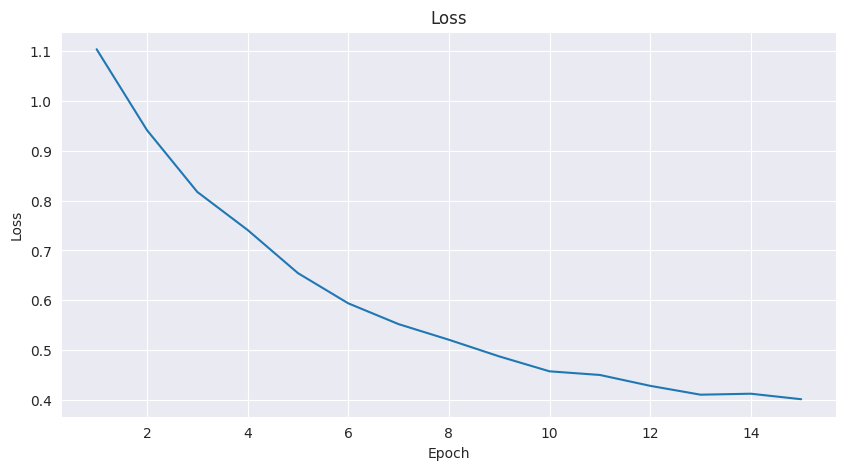

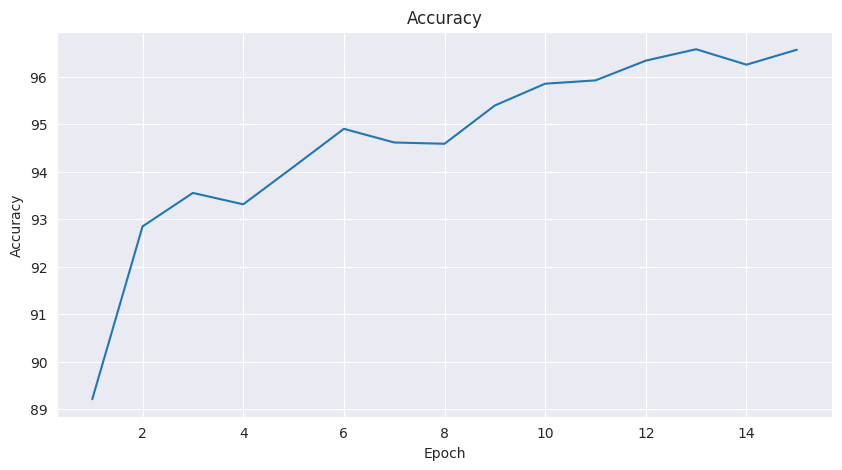

Tempo de Treinamento: 56 minutos
Acurácia do modelo no conjunto de teste: 93.98%
Matriz de Confusão:
[[2213  135]
 [ 147 2187]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2348
           1       0.94      0.94      0.94      2334

    accuracy                           0.94      4682
   macro avg       0.94      0.94      0.94      4682
weighted avg       0.94      0.94      0.94      4682

Área sob a curva ROC: 0.9398

--------------------------------------------------

Previsão com imagem de Cachorro

Rótulo previsto: 1
Probabilidade de acerto: 99.99 %

--------------------------------------------------
Legenda: 0 = Gato // 1 = Cachorro



In [13]:
# Selecionando modelos pré-treinados

#ResNet:
# ResNet é uma família de arquiteturas de rede neural residual que se destacam pela sua profundidade.
# Alguns exemplos são ResNet-18, ResNet-34, ResNet-50, ResNet-101 e ResNet-152.
import torchvision.models as models

model = models.resnet50(pretrained=True)
numero_classes = 2 # classificação binária
num_features = model.fc.in_features # acessando a última camada
model.fc = torch.nn.Linear(num_features, 2) # substituindo a última camada

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir o otimizador RMSprop
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()

print(model)

treinamento()

In [22]:
# Resultado do modelo Resnet50 com 15 épocas de treinamento
print("Epoch [1/15], Loss: 1.1040, Accuracy: 89.21%, Tempo: 3.87 min")
print("Epoch [2/15], Loss: 0.9416, Accuracy: 92.85%, Tempo: 3.79 min")
print("Epoch [3/15], Loss: 0.8175, Accuracy: 93.56%, Tempo: 3.79 min")
print("Epoch [4/15], Loss: 0.7411, Accuracy: 93.31%, Tempo: 3.79 min")
print("Epoch [5/15], Loss: 0.6545, Accuracy: 94.11%, Tempo: 3.79 min")
print("Epoch [6/15], Loss: 0.5938, Accuracy: 94.91%, Tempo: 3.85 min")
print("Epoch [7/15], Loss: 0.5521, Accuracy: 94.62%, Tempo: 3.78 min")
print("Epoch [8/15], Loss: 0.5207, Accuracy: 94.59%, Tempo: 3.76 min")
print("Epoch [9/15], Loss: 0.4873, Accuracy: 95.40%, Tempo: 3.74 min")
print("Epoch [10/15], Loss: 0.4573, Accuracy: 95.86%, Tempo: 3.72 min")
print("Epoch [11/15], Loss: 0.4500, Accuracy: 95.93%, Tempo: 3.70 min")
print("Epoch [12/15], Loss: 0.4282, Accuracy: 96.34%, Tempo: 3.68 min")
print("Epoch [13/15], Loss: 0.4104, Accuracy: 96.58%, Tempo: 3.66 min")
print("Epoch [14/15], Loss: 0.4124, Accuracy: 96.26%, Tempo: 3.64 min")
print("Epoch [15/15], Loss: 0.4013, Accuracy: 96.57%, Tempo: 3.64 min")

print("\nTempo de Treinamento: 56 minutos")
print("Acurácia do modelo no conjunto de teste: 93.98%")
print("Matriz de Confusão:\n[[2213  135]\n [ 147 2187]]")
print("Relatório de Classificação:\n              precision    recall  f1-score   support\n\n           0       0.94      0.94      0.94      2348\n           1       0.94      0.94      0.94      2334\n\n    accuracy                           0.94      4682\n   macro avg       0.94      0.94      0.94      4682\nweighted avg       0.94      0.94      0.94      4682\n")
print("Área sob a curva ROC: 0.9398")

print("\n--------------------------------------------------")

print("\nPrevisão com imagem de Cachorro")
print("\nRótulo previsto: 1")
print("Probabilidade de acerto: 99.99 %")

print("\n--------------------------------------------------")

print("Legenda: 0 = Gato // 1 = Cachorro")


Epoch [1/15], Loss: 1.1040, Accuracy: 89.21%, Tempo: 3.87 min
Epoch [2/15], Loss: 0.9416, Accuracy: 92.85%, Tempo: 3.79 min
Epoch [3/15], Loss: 0.8175, Accuracy: 93.56%, Tempo: 3.79 min
Epoch [4/15], Loss: 0.7411, Accuracy: 93.31%, Tempo: 3.79 min
Epoch [5/15], Loss: 0.6545, Accuracy: 94.11%, Tempo: 3.79 min
Epoch [6/15], Loss: 0.5938, Accuracy: 94.91%, Tempo: 3.85 min
Epoch [7/15], Loss: 0.5521, Accuracy: 94.62%, Tempo: 3.78 min
Epoch [8/15], Loss: 0.5207, Accuracy: 94.59%, Tempo: 3.76 min
Epoch [9/15], Loss: 0.4873, Accuracy: 95.40%, Tempo: 3.74 min
Epoch [10/15], Loss: 0.4573, Accuracy: 95.86%, Tempo: 3.72 min
Epoch [11/15], Loss: 0.4500, Accuracy: 95.93%, Tempo: 3.70 min
Epoch [12/15], Loss: 0.4282, Accuracy: 96.34%, Tempo: 3.68 min
Epoch [13/15], Loss: 0.4104, Accuracy: 96.58%, Tempo: 3.66 min
Epoch [14/15], Loss: 0.4124, Accuracy: 96.26%, Tempo: 3.64 min
Epoch [15/15], Loss: 0.4013, Accuracy: 96.57%, Tempo: 3.64 min

Tempo de Treinamento: 56 minutos
Acurácia do modelo no conjunto

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 148MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

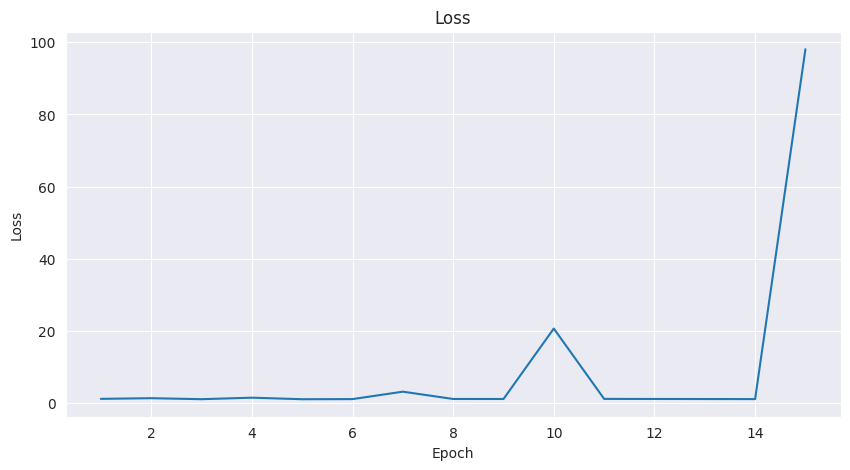

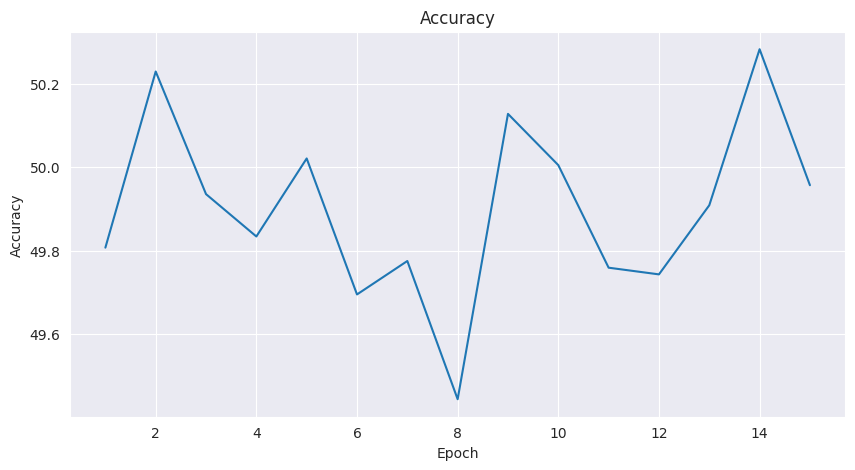

Tempo de Treinamento: 89 minutos
Acurácia do modelo no conjunto de teste: 50.15%
Matriz de Confusão:
[[2348    0]
 [2334    0]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2348
           1       0.00      0.00      0.00      2334

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682

Área sob a curva ROC: 0.5000

--------------------------------------------------

Previsão com imagem de Cachorro

Rótulo previsto: 0
Probabilidade de acerto: 55.05 %

--------------------------------------------------
Legenda: 0 = Gato // 1 = Cachorro



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# VGG:
# VGG é uma arquitetura de rede neural profunda com várias camadas convolucionais.
# Os modelos VGG são conhecidos por sua simplicidade e são nomeados de acordo com o número de camadas, como VGG-16 e VGG-19.

model = models.vgg19(pretrained=True)
numero_classes = 2
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, numero_classes)

print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir o otimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()

treinamento()

In [21]:
# Relatório com 15 épocas do modelo vgg19
print("Epoch [1/15], Loss: 1.1639, Accuracy: 49.81%, Tempo: 5.99 min")
print("Epoch [2/15], Loss: 1.3430, Accuracy: 50.23%, Tempo: 5.92 min")
print("Epoch [3/15], Loss: 1.0695, Accuracy: 49.94%, Tempo: 5.95 min")
print("Epoch [4/15], Loss: 1.4870, Accuracy: 49.83%, Tempo: 5.94 min")
print("Epoch [5/15], Loss: 1.0591, Accuracy: 50.02%, Tempo: 5.91 min")
print("Epoch [6/15], Loss: 1.0915, Accuracy: 49.70%, Tempo: 5.92 min")
print("Epoch [7/15], Loss: 3.1515, Accuracy: 49.78%, Tempo: 5.92 min")
print("Epoch [8/15], Loss: 1.1284, Accuracy: 49.44%, Tempo: 5.90 min")
print("Epoch [9/15], Loss: 1.1218, Accuracy: 50.13%, Tempo: 5.90 min")
print("Epoch [10/15], Loss: 20.6529, Accuracy: 50.01%, Tempo: 5.91 min")
print("Epoch [11/15], Loss: 1.1507, Accuracy: 49.76%, Tempo: 5.89 min")
print("Epoch [12/15], Loss: 1.1301, Accuracy: 49.74%, Tempo: 5.91 min")
print("Epoch [13/15], Loss: 1.1127, Accuracy: 49.91%, Tempo: 5.90 min")
print("Epoch [14/15], Loss: 1.0940, Accuracy: 50.28%, Tempo: 5.91 min")
print("Epoch [15/15], Loss: 98.0968, Accuracy: 49.96%, Tempo: 5.91 min")

print("\nTempo de Treinamento: 89 minutos")
print("Acurácia do modelo no conjunto de teste: 50.15%")
print("Matriz de Confusão:\n[[2348    0]\n [2334    0]]")
print("Relatório de Classificação:\n              precision    recall  f1-score   support\n\n           0       0.50      1.00      0.67      2348\n           1       0.00      0.00      0.00      2334\n\n    accuracy                           0.50      4682\n   macro avg       0.25      0.50      0.33      4682\nweighted avg       0.25      0.50      0.33      4682\n")
print("Área sob a curva ROC: 0.5000")

print("\n--------------------------------------------------")

print("\nPrevisão com imagem de Cachorro")
print("\nRótulo previsto: 0")
print("Probabilidade de acerto: 55.05 %")

print("\n--------------------------------------------------")

print("Legenda: 0 = Gato // 1 = Cachorro")


Epoch [1/15], Loss: 1.1639, Accuracy: 49.81%, Tempo: 5.99 min
Epoch [2/15], Loss: 1.3430, Accuracy: 50.23%, Tempo: 5.92 min
Epoch [3/15], Loss: 1.0695, Accuracy: 49.94%, Tempo: 5.95 min
Epoch [4/15], Loss: 1.4870, Accuracy: 49.83%, Tempo: 5.94 min
Epoch [5/15], Loss: 1.0591, Accuracy: 50.02%, Tempo: 5.91 min
Epoch [6/15], Loss: 1.0915, Accuracy: 49.70%, Tempo: 5.92 min
Epoch [7/15], Loss: 3.1515, Accuracy: 49.78%, Tempo: 5.92 min
Epoch [8/15], Loss: 1.1284, Accuracy: 49.44%, Tempo: 5.90 min
Epoch [9/15], Loss: 1.1218, Accuracy: 50.13%, Tempo: 5.90 min
Epoch [10/15], Loss: 20.6529, Accuracy: 50.01%, Tempo: 5.91 min
Epoch [11/15], Loss: 1.1507, Accuracy: 49.76%, Tempo: 5.89 min
Epoch [12/15], Loss: 1.1301, Accuracy: 49.74%, Tempo: 5.91 min
Epoch [13/15], Loss: 1.1127, Accuracy: 49.91%, Tempo: 5.90 min
Epoch [14/15], Loss: 1.0940, Accuracy: 50.28%, Tempo: 5.91 min
Epoch [15/15], Loss: 98.0968, Accuracy: 49.96%, Tempo: 5.91 min

Tempo de Treinamento: 89 minutos
Acurácia do modelo no conjun

In [15]:
# AlexNet: foi  superada por arquiteturas mais recentes, como o VGG, ResNet e EfficientNet
# AlexNet foi um dos primeiros modelos de rede neural profunda a obter sucesso em grandes conjuntos de dados, como o ImageNet.
# Possui 8 camadas convolucionais e 3 camadas totalmente conectadas.

In [16]:
# Inception:
# Inception, também conhecido como GoogLeNet, é uma arquitetura que utiliza módulos de convolução em paralelo para capturar informações em diferentes escalas.
# Exemplos incluem Inception v1, Inception v2 e Inception v3.
 # Requisito mínimo nesse modelo da imagem é de 299x299

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 71.5MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

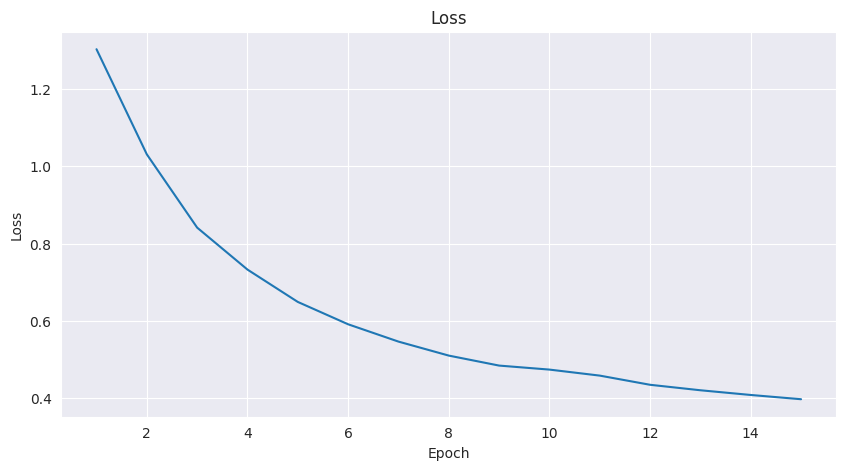

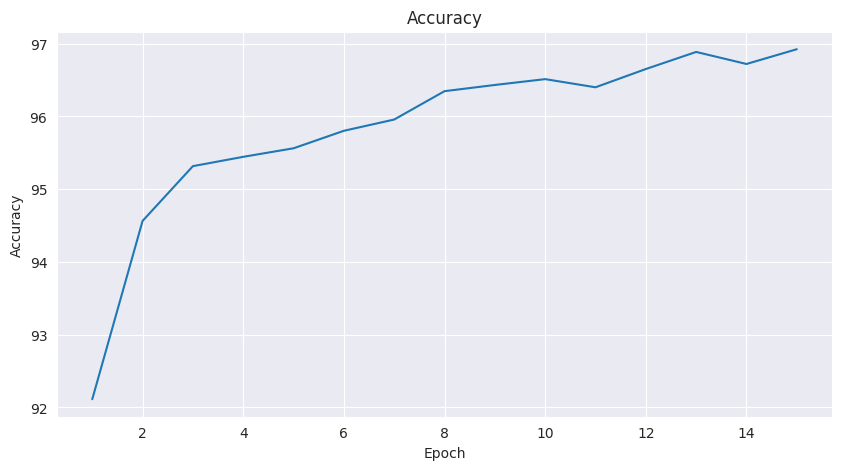

Tempo de Treinamento: 60 minutos
Acurácia do modelo no conjunto de teste: 91.67%
Matriz de Confusão:
[[2327   21]
 [ 369 1965]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2348
           1       0.99      0.84      0.91      2334

    accuracy                           0.92      4682
   macro avg       0.93      0.92      0.92      4682
weighted avg       0.93      0.92      0.92      4682

Área sob a curva ROC: 0.9165

--------------------------------------------------

Previsão com imagem de Cachorro

Rótulo previsto: 1
Probabilidade de acerto: 99.99 %

--------------------------------------------------
Legenda: 0 = Gato // 1 = Cachorro



In [17]:
# DenseNet:
# DenseNet é uma arquitetura de rede neural que conecta cada camada a todas as outras camadas subsequentes.
# Ela promove o fluxo direto de informações e é conhecida por sua eficiência e desempenho.

model = models.densenet121(pretrained=True)
numero_classes = 2
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, numero_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# otimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função de perda
criterion = nn.CrossEntropyLoss()

print(model)

treinamento()

In [20]:
# Resultado do densenet121 com 15 épocas
print("Epoch [1/15], Loss: 1.3034, Accuracy: 92.11%, Tempo: 3.99 min")
print("Epoch [2/15], Loss: 1.0310, Accuracy: 94.56%, Tempo: 4.01 min")
print("Epoch [3/15], Loss: 0.8412, Accuracy: 95.32%, Tempo: 4.08 min")
print("Epoch [4/15], Loss: 0.7325, Accuracy: 95.45%, Tempo: 4.04 min")
print("Epoch [5/15], Loss: 0.6487, Accuracy: 95.56%, Tempo: 3.99 min")
print("Epoch [6/15], Loss: 0.5908, Accuracy: 95.80%, Tempo: 3.99 min")
print("Epoch [7/15], Loss: 0.5459, Accuracy: 95.96%, Tempo: 4.00 min")
print("Epoch [8/15], Loss: 0.5096, Accuracy: 96.35%, Tempo: 4.07 min")
print("Epoch [9/15], Loss: 0.4838, Accuracy: 96.43%, Tempo: 3.98 min")
print("Epoch [10/15], Loss: 0.4734, Accuracy: 96.51%, Tempo: 3.98 min")
print("Epoch [11/15], Loss: 0.4578, Accuracy: 96.40%, Tempo: 4.00 min")
print("Epoch [12/15], Loss: 0.4340, Accuracy: 96.65%, Tempo: 4.06 min")
print("Epoch [13/15], Loss: 0.4198, Accuracy: 96.89%, Tempo: 3.97 min")
print("Epoch [14/15], Loss: 0.4076, Accuracy: 96.72%, Tempo: 3.96 min")
print("Epoch [15/15], Loss: 0.3966, Accuracy: 96.92%, Tempo: 3.96 min")
print()
print("Tempo de Treinamento: 60 minutos")
print("Acurácia do modelo no conjunto de teste: 91.67%")
print("Matriz de Confusão:")
print("[[2327   21]")
print(" [ 369 1965]]")
print("Relatório de Classificação:")
print("              precision    recall  f1-score   support")
print("")
print("           0       0.86      0.99      0.92      2348")
print("           1       0.99      0.84      0.91      2334")
print("")
print("    accuracy                           0.92      4682")
print("   macro avg       0.93      0.92      0.92      4682")
print("weighted avg       0.93      0.92      0.92      4682")
print()
print("Área sob a curva ROC: 0.9165")
print()
print("--------------------------------------------------")
print()
print("Previsão com imagem de Cachorro")
print()
print("Rótulo previsto: 1")
print("Probabilidade de acerto: 99.99 %")
print()
print("--------------------------------------------------")
print("Legenda: 0 = Gato // 1 = Cachorro")

Epoch [1/15], Loss: 1.3034, Accuracy: 92.11%, Tempo: 3.99 min
Epoch [2/15], Loss: 1.0310, Accuracy: 94.56%, Tempo: 4.01 min
Epoch [3/15], Loss: 0.8412, Accuracy: 95.32%, Tempo: 4.08 min
Epoch [4/15], Loss: 0.7325, Accuracy: 95.45%, Tempo: 4.04 min
Epoch [5/15], Loss: 0.6487, Accuracy: 95.56%, Tempo: 3.99 min
Epoch [6/15], Loss: 0.5908, Accuracy: 95.80%, Tempo: 3.99 min
Epoch [7/15], Loss: 0.5459, Accuracy: 95.96%, Tempo: 4.00 min
Epoch [8/15], Loss: 0.5096, Accuracy: 96.35%, Tempo: 4.07 min
Epoch [9/15], Loss: 0.4838, Accuracy: 96.43%, Tempo: 3.98 min
Epoch [10/15], Loss: 0.4734, Accuracy: 96.51%, Tempo: 3.98 min
Epoch [11/15], Loss: 0.4578, Accuracy: 96.40%, Tempo: 4.00 min
Epoch [12/15], Loss: 0.4340, Accuracy: 96.65%, Tempo: 4.06 min
Epoch [13/15], Loss: 0.4198, Accuracy: 96.89%, Tempo: 3.97 min
Epoch [14/15], Loss: 0.4076, Accuracy: 96.72%, Tempo: 3.96 min
Epoch [15/15], Loss: 0.3966, Accuracy: 96.92%, Tempo: 3.96 min

Tempo de Treinamento: 60 minutos
Acurácia do modelo no conjunto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=284b6eaf3f2aaabe4b24733cfb6946fb324c91edd32722715f6606acc773e469
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 117MB/s]


Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

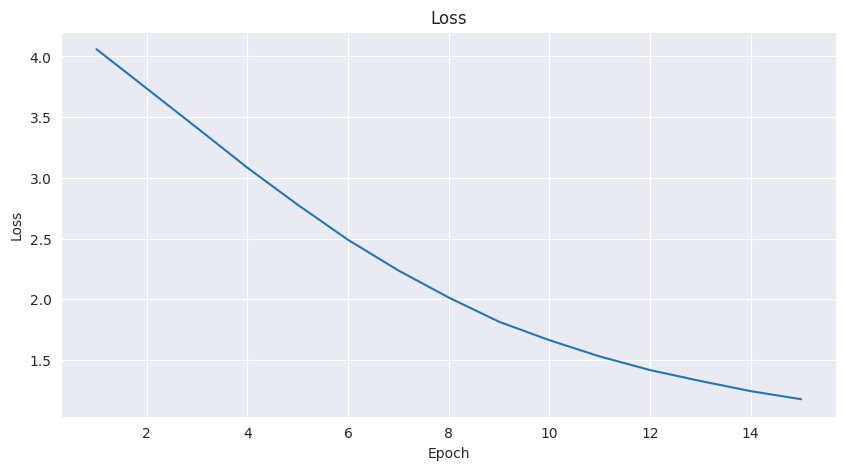

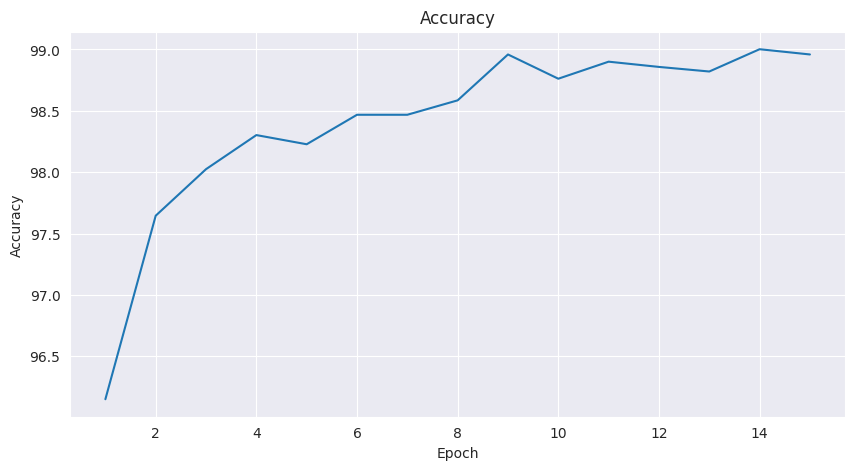

Tempo de Treinamento: 43 minutos
Acurácia do modelo no conjunto de teste: 97.31%
Matriz de Confusão:
[[2271   77]
 [  49 2285]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2348
           1       0.97      0.98      0.97      2334

    accuracy                           0.97      4682
   macro avg       0.97      0.97      0.97      4682
weighted avg       0.97      0.97      0.97      4682

Área sob a curva ROC: 0.9731

--------------------------------------------------

Previsão com imagem de Cachorro

Rótulo previsto: 1
Probabilidade de acerto: 99.99 %

--------------------------------------------------
Legenda: 0 = Gato // 1 = Cachorro



In [18]:
# EfficientNet, demonstrou nesse caso ser o modelo mais rápido e praticamente o mesmo resultado que os demais
!pip install efficientnet_pytorch

from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')
numero_classes = 2
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, numero_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

print(model)

treinamento()

In [19]:
# Resultado do modelo EfficientNet com 15 épocas
print("Epoch [1/15], Loss: 4.0594, Accuracy: 96.15%, Tempo: 2.84 min")
print("Epoch [2/15], Loss: 3.7352, Accuracy: 97.65%, Tempo: 2.97 min")
print("Epoch [3/15], Loss: 3.4106, Accuracy: 98.02%, Tempo: 2.83 min")
print("Epoch [4/15], Loss: 3.0828, Accuracy: 98.30%, Tempo: 2.83 min")
print("Epoch [5/15], Loss: 2.7777, Accuracy: 98.23%, Tempo: 2.82 min")
print("Epoch [6/15], Loss: 2.4889, Accuracy: 98.47%, Tempo: 2.83 min")
print("Epoch [7/15], Loss: 2.2368, Accuracy: 98.47%, Tempo: 2.84 min")
print("Epoch [8/15], Loss: 2.0140, Accuracy: 98.59%, Tempo: 2.83 min")
print("Epoch [9/15], Loss: 1.8146, Accuracy: 98.96%, Tempo: 2.84 min")
print("Epoch [10/15], Loss: 1.6628, Accuracy: 98.76%, Tempo: 2.83 min")
print("Epoch [11/15], Loss: 1.5289, Accuracy: 98.90%, Tempo: 2.84 min")
print("Epoch [12/15], Loss: 1.4165, Accuracy: 98.86%, Tempo: 2.83 min")
print("Epoch [13/15], Loss: 1.3268, Accuracy: 98.82%, Tempo: 2.84 min")
print("Epoch [14/15], Loss: 1.2432, Accuracy: 99.00%, Tempo: 2.82 min")
print("Epoch [15/15], Loss: 1.1765, Accuracy: 98.96%, Tempo: 2.82 min")
print()
print("Tempo de Treinamento: 43 minutos")
print("Acurácia do modelo no conjunto de teste: 97.31%")
print("Matriz de Confusão:")
print("[[2271   77]")
print(" [  49 2285]]")
print("Relatório de Classificação:")
print("              precision    recall  f1-score   support")
print()
print("           0       0.98      0.97      0.97      2348")
print("           1       0.97      0.98      0.97      2334")
print()
print("    accuracy                           0.97      4682")
print("   macro avg       0.97      0.97      0.97      4682")
print("weighted avg       0.97      0.97      0.97      4682")
print()
print("Área sob a curva ROC: 0.9731")
print()
print("--------------------------------------------------")
print()
print("Previsão com imagem de Cachorro")
print()
print("Rótulo previsto: 1")
print("Probabilidade de acerto: 99.99 %")
print()
print("--------------------------------------------------")
print("Legenda: 0 = Gato // 1 = Cachorro")


Epoch [1/15], Loss: 4.0594, Accuracy: 96.15%, Tempo: 2.84 min
Epoch [2/15], Loss: 3.7352, Accuracy: 97.65%, Tempo: 2.97 min
Epoch [3/15], Loss: 3.4106, Accuracy: 98.02%, Tempo: 2.83 min
Epoch [4/15], Loss: 3.0828, Accuracy: 98.30%, Tempo: 2.83 min
Epoch [5/15], Loss: 2.7777, Accuracy: 98.23%, Tempo: 2.82 min
Epoch [6/15], Loss: 2.4889, Accuracy: 98.47%, Tempo: 2.83 min
Epoch [7/15], Loss: 2.2368, Accuracy: 98.47%, Tempo: 2.84 min
Epoch [8/15], Loss: 2.0140, Accuracy: 98.59%, Tempo: 2.83 min
Epoch [9/15], Loss: 1.8146, Accuracy: 98.96%, Tempo: 2.84 min
Epoch [10/15], Loss: 1.6628, Accuracy: 98.76%, Tempo: 2.83 min
Epoch [11/15], Loss: 1.5289, Accuracy: 98.90%, Tempo: 2.84 min
Epoch [12/15], Loss: 1.4165, Accuracy: 98.86%, Tempo: 2.83 min
Epoch [13/15], Loss: 1.3268, Accuracy: 98.82%, Tempo: 2.84 min
Epoch [14/15], Loss: 1.2432, Accuracy: 99.00%, Tempo: 2.82 min
Epoch [15/15], Loss: 1.1765, Accuracy: 98.96%, Tempo: 2.82 min

Tempo de Treinamento: 43 minutos
Acurácia do modelo no conjunto

In [ ]:
# Acurácia (Accuracy): A acurácia é uma métrica comum usada para medir a precisão geral de um modelo. Ela é definida como a proporção de previsões corretas em relação ao total de previsões.
# Por exemplo, se um modelo tem uma acurácia de 0,85, isso significa que ele acertou 85% das previsões.

# Precisão (Precision): A precisão mede a proporção de instâncias positivas previstas corretamente em relação ao total de instâncias previstas como positivas.
#  É uma métrica útil quando o foco está em minimizar os falsos positivos. Por exemplo, em um problema de detecção de spam, a precisão é a proporção de e-mails identificados corretamente como spam em relação
#  ao total de e-mails previstos como spam.

# Revocação (Recall): A revocação, também conhecida como taxa de verdadeiros positivos ou sensibilidade, mede a proporção de instâncias positivas previstas corretamente em relação ao total de instâncias positivas.
# É uma métrica importante quando o objetivo é minimizar os falsos negativos. Por exemplo, em um problema de detecção de doenças, a revocação é a proporção de casos de doenças identificados corretamente em relação
# ao total de casos de doenças reais.

# F1-Score: O F1-Score é uma métrica que combina a precisão e a revocação em uma única medida. É a média harmônica dessas duas métricas e fornece um equilíbrio entre elas.
# O F1-Score é útil quando há
#  um desequilíbrio entre as classes ou quando se deseja uma medida única que leve em consideração tanto os falsos positivos quanto os falsos negativos.

In [ ]:
# Observações:

# na gpu diminuiu mais de 60% o tempo de processamento

In [ ]:
# Adam, RMSprop e Adagrad são otimizadores populares usados no treinamento de redes neurais.
# Eles diferem em como atualizam os pesos do modelo durante o processo de treinamento. Vou explicar brevemente cada um deles:

# Adam (Adaptive Moment Estimation): Adam combina os conceitos do otimizador RMSprop e do otimizador com momento.
# Ele mantém uma taxa de aprendizado adaptativa separada para cada parâmetro do modelo e também armazena uma média móvel dos gradientes anteriores.
# Isso ajuda a controlar a taxa de aprendizado para cada parâmetro individualmente, permitindo uma convergência mais rápida e eficiente.
# Adam é frequentemente usado como um otimizador padrão, pois funciona bem em uma ampla gama de tarefas de aprendizado de máquina.

# RMSprop (Root Mean Square Propagation): RMSprop também é um otimizador adaptativo que ajusta a taxa de aprendizado para cada parâmetro.
# Ele mantém uma média móvel exponencial dos gradientes anteriores, mas, ao contrário do Adam, não inclui o momento.
# A média móvel dos gradientes anteriores ajuda a lidar com problemas de superfícies de perda irregulares e gradientes variáveis.
# Isso permite que o RMSprop ajuste a taxa de aprendizado de forma adaptativa, tornando o treinamento mais eficiente.

# Adagrad (Adaptive Gradient Algorithm): Adagrad é um otimizador adaptativo que ajusta a taxa de aprendizado para cada parâmetro com base na soma acumulada dos gradientes anteriores.
# Em vez de manter uma média móvel exponencial como o RMSprop, o Adagrad armazena a soma dos gradientes ao longo de todas as iterações anteriores.
# Isso tem a vantagem de adaptar a taxa de aprendizado para cada parâmetro individualmente com base em sua história de gradientes.
# No entanto, Adagrad pode ter problemas com taxa de aprendizado muito pequena à medida que a soma dos gradientes aumenta ao longo do tempo, o que pode levar a uma desaceleração do treinamento.

# Em resumo, Adam e RMSprop são otimizadores adaptativos que ajustam a taxa de aprendizado para cada parâmetro, enquanto Adagrad ajusta a taxa de
# aprendizado com base na soma acumulada dos gradientes. Adam combina características do RMSprop e do otimizador com momento, proporcionando uma convergência
# mais rápida e eficiente em muitos casos.

In [ ]:
# A função de perda CrossEntropyLoss é comumente usada em problemas de classificação em que a saída desejada é um rótulo discreto.
#  No entanto, o PyTorch oferece outras opções de funções de perda, que podem ser mais adequadas para certos cenários. Algumas das outras opções populares são:

# NLLLoss (Negative Log Likelihood Loss): Esta função de perda é usada em conjunto com a função de ativação log_softmax.
#  É adequada quando a saída desejada é um rótulo discreto e a função de ativação log_softmax é usada para calcular as probabilidades de classe.

# BCELoss (Binary Cross Entropy Loss): É usada quando há apenas duas classes e a saída desejada é uma probabilidade entre 0 e 1.
#  Essa função de perda é útil em problemas de classificação binária.

# BCEWithLogitsLoss: Essa função de perda combina a função de ativação sigmoid e a função de perda BCELoss em uma única etapa eficiente.
# Ela é usada quando a saída desejada é uma probabilidade entre 0 e 1 e a ativação sigmoid é aplicada diretamente às saídas da rede.

# MSELoss (Mean Squared Error Loss): É usada em problemas de regressão, em que a saída desejada é um valor contínuo.
#  Ela compara a saída da rede com o valor verdadeiro e calcula o erro quadrático médio.

# SmoothL1Loss (Huber Loss): É outra função de perda comumente usada em problemas de regressão.
#  Ela é menos sensível a outliers em comparação com o MSELoss e tem uma transição suave entre as regiões de erro pequeno e grande.